# Comparison to the Water Budget: Data Processing

We want to compare the changes of our reconstructed water storage anomalies to the water balance equation, calculated from ERA5.

In [1]:
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec.utils import ROOT_DIR
from deeprec.visualization import plot_grace_gap

In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")

# Register dask progress bar
ProgressBar(minimum=5).register()

## Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [2]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [3]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [4]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, ours, recs])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


In [5]:
# rename variables containing twsa in their name
renamer = {
    dvar: dvar.removeprefix("twsa_") for dvar in ds_all.data_vars if "twsa_" in dvar
}
ds_all = ds_all.rename(renamer)

In [6]:
vars_verbose = {
    "ours_era-rdcd": "DeepRec, 4×ERA5",
    "ours_era": "DeepRec, 14×ERA5",
    "ours_wghm-era": "DeepRec, WGHM+14×ERA5",
    "gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "csr": "CSR (GRACE)",
}
eval_names = list(vars_verbose.keys())

In [7]:
# Variables of interest
grace_name = "csr"
era_names = ["era5_tp", "era5_e", "era5_ro"]


We generate basin scale time-series by averaging all grid points of basins larger than 200 000 km².

In [8]:
CALC = True

twsa_basin_path = ROOT_DIR / "data/evaluations/twsa_basin-scale.zarr"

if CALC:
    ds_basin = (
        # Select variables and time frame of interest
        ds_all[[*eval_names, *era_names]]
        .sel(time=slice("1940", None))
        .chunk(time=10, lat=-1, lon=-1)
        .dr.select_basins(top=72)
        .dr.weight_lat()
        .mean(["lat", "lon"])
        .compute()
    )
    ds_basin.to_zarr(twsa_basin_path, mode="w")
else:
    ds_basin = xr.open_zarr(twsa_basin_path)

ds_basin

[########################################] | 100% Completed | 345.59 s


<xarray.Dataset> Size: 6MB
Dimensions:                (time: 1017, region: 72)
Coordinates:
  * time                   (time) datetime64[ns] 8kB 1940-01-01 ... 2024-09-01
  * region                 (region) object 576B 'Amazon' 'Congo' ... 'Ural'
Data variables:
    ours_era-rdcd          (region, time) float64 586kB nan nan nan ... nan nan
    ours_era               (region, time) float64 586kB nan nan nan ... nan nan
    ours_wghm-era          (region, time) float64 586kB nan nan nan ... nan nan
    gap                    (region, time) float64 586kB 46.07 105.6 ... nan nan
    humphrey_gsfc_detrend  (region, time) float64 586kB nan nan nan ... nan nan
    li_csr_full            (region, time) float64 586kB nan nan nan ... nan nan
    yin_csr_full           (region, time) float64 586kB -72.29 -14.44 ... nan
    csr                    (region, time) float64 586kB nan nan ... -87.66
    era5_tp                (region, time) float64 586kB 0.00637 0.006975 ... nan
    era5_e                 (region, time) float64 586kB -0.003766 ... nan
    era5_ro                (region, time) float64 586kB 0.002997 ... nan

### GRACE time step interpolation

We did not perform interpolation when using GRACE as a target. In this evaluation, GRACE only serves as a comparison and continuous time steps are important for the subsequent differentiation, so we perform a quadratic interpolation.

In [9]:
def grace_time_interp(
    da: xr.DataArray, method: Literal["linear", "quadratic", "cubic"] = "linear"
) -> xr.DataArray:
    # Remove missing time steps
    da = da.dropna("time", how="all")

    # Create full time index without missing steps
    grace_time = da.get_index("time")
    start, end = grace_time[0], grace_time[-1]
    full_time = pd.date_range(start, end, freq="MS")

    # Perform interpolation of missing time steps
    return da.interp(time=full_time, method=method)

In [10]:
# Before interpolation, split in GRACE and GRACE-FO
# Due to the long gap, we have to perform the interpolation on them individually
grace_og = ds_basin[grace_name].sel(time=slice(None, "2018-01"))
grace_fo = ds_basin[grace_name].sel(time=slice("2018-01", None))

# Perform interpolation
grace_og = grace_time_interp(grace_og, method="quadratic")
grace_fo = grace_time_interp(grace_fo, method="quadratic")

# Combine GRACE and GRACE-FO
grace_interp = xr.concat([grace_og, grace_fo], dim="time").rename("csr_interp")

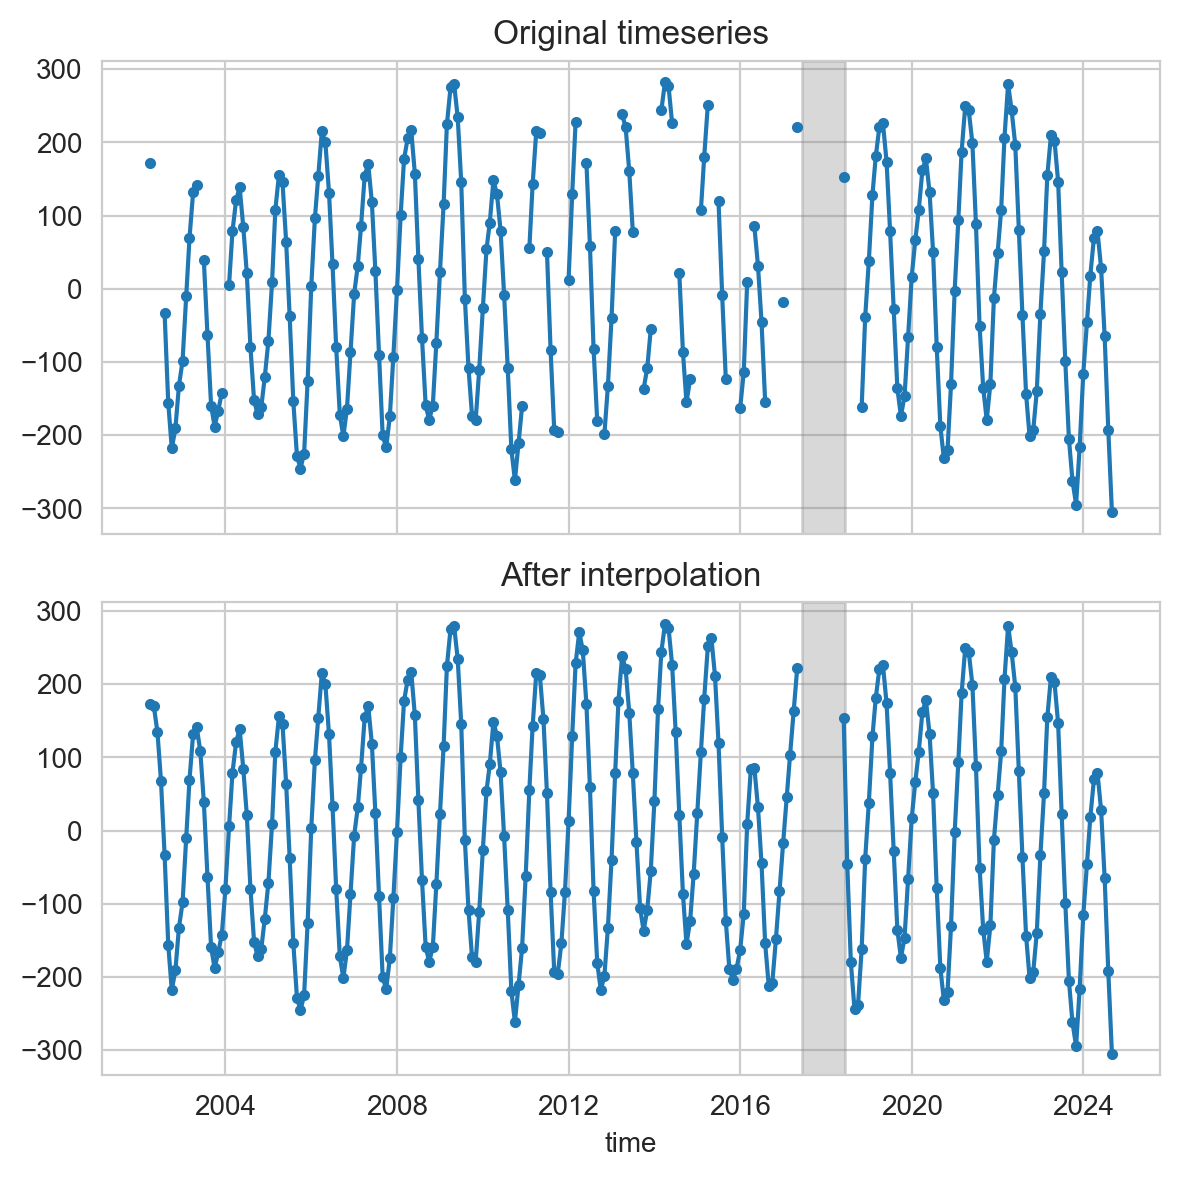

In [11]:
# Plot the result
p = (
    xr.merge([ds_basin[grace_name], grace_interp])
    .to_dataarray()
    .sel(region="Amazon")
    .dr.insert_grace_gap_nans()
    .plot(row="variable", marker=".", figsize=(6, 6))
)
axs = p.axs.flat
axs[0].set_title("Original timeseries")
axs[1].set_title("After interpolation")
for ax in axs:
    plot_grace_gap(ax)

In [12]:
# Replace GRACE time series with interpolation
ds_basin[grace_name] = grace_interp

### Calculate the TWSC from the reconstructions

For this, we have to calculate the water storage changes with the central difference:

$$  \text{TWSC}(t) = \frac{\text{TWS}(t + 1) - \text{TWS}(t - 1)}{2 \Delta t} $$

$\Delta t$ is our base time interval, 1 month.

In [13]:
T_DELTA = 1

tws_eval = ds_basin[eval_names]
forward_shift = tws_eval.shift(time=-1)
backward_shift = tws_eval.shift(time=1)
twsc_eval = (forward_shift - backward_shift) / (2 * T_DELTA)

### Calculate the TWSC from ERA5

We calculate the TWSC first with the ERA5 components according to the water balance equation:

$$ \text{TWSC} = \frac{d\text{TWS}}{dt} = P - ET - R $$

According to the ECMWF Integrated Forecasting System (IFS) convention, downward fluxes are positive. We therefore have to add $ET$ instead if subtracting it in our implementation.

In [14]:
MM_PER_M = 1000
DAYS_PER_MONTH = 365.25 / 12

# Evaporation is negatively defined, so add instead of subtract
twsc_bdgt = ds_basin.era5_tp + ds_basin.era5_e - ds_basin.era5_ro
# Convert from m/day to mm/month
twsc_bdgt *= MM_PER_M * DAYS_PER_MONTH

We use the following equation to match the temporal shift induced by the central difference:

$$ \tilde X = \frac{1}{4} X(t-1) + \frac{1}{2} X(t) + \frac{1}{4} X(t+1) $$

We implement this for our Xarray data array by averaging over a weighted rolling window:

In [15]:
weights = xr.DataArray(np.array([1.0, 2.0, 1.0], dtype="float32"), dims="time_roll")

twsc_bdgt_smooth = (
    twsc_bdgt.dropna("time", how="all")
    .rolling(time=3, center=True)
    .construct("time_roll")
    .weighted(weights)
    .mean("time_roll", skipna=False)
)

### Combine and save

In [16]:
twsc_basin_path = ROOT_DIR / "data/evaluations/twsc_basin-scale.zarr"

twsc = (
    xr.merge(
        [twsc_eval, twsc_bdgt.rename("era5"), twsc_bdgt_smooth.rename("era5_smooth")]
    )
    .drop_encoding()
    .chunk(region=-1, time=-1)
)
twsc.to_zarr(twsc_basin_path, mode="w")

### Validation

Compare our calculations for a single basin

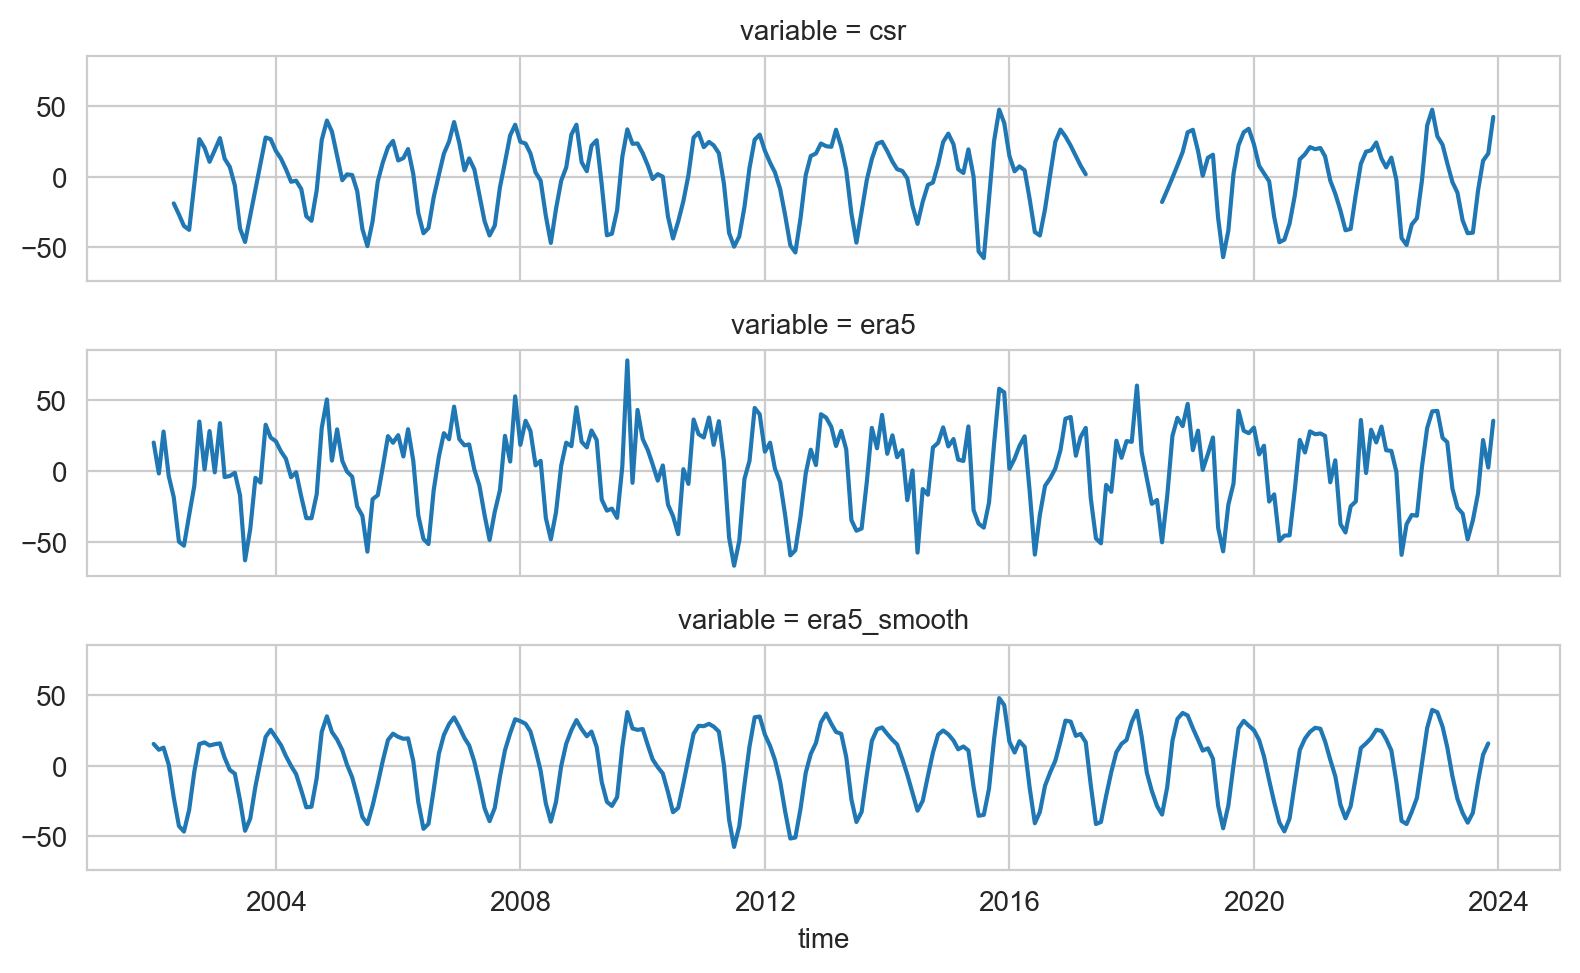

In [17]:
da_plot = (
    twsc[["csr", "era5", "era5_smooth"]]
    .sel(region="Mississippi", time=slice("2002", "2023"))
    .to_dataarray()
)
da_plot.plot(row="variable", figsize=(8, 5))